# Recommendation System for Restaurants across a Number of Cities

Working as a Trip Advisor in Booking.com it is arduous to manually search a database for restaurants that customers may appreciate. It is time-consuming and exhausting to match clients' preferences in cuisines and pricing, as well as select the highest-rated restaurants, alone. 

With this notebook, I will ease the process of a Trip Advisor by creating two recommendation systems that automatically does the necessary searches.

I gathered my data from the following kaggle dataset:
https://www.kaggle.com/datasets/damienbeneschi/krakow-ta-restaurans-data-raw

In this notebook, I will begin with the necessary steps to prep for the recommendation systems. I will then use Sentiment Analysis to isolate Positive, Neutral, and Negative reviews, furthermore I will recommend restaurants based on the more positive reviews as well as the higher scored rating. Also, given a previously tried restaurant from the customer, I will use the contents given in the dataset to compare them: content based recommendation system. Using data such as pricing and cuisine types, I will be able to find similarities with the inital restaurant and come up with the best recommendations for the customer. 

## 0) IMPORTING LIBRARIES & CREATING THE AGENDA

In [1]:
## Step 1: Loading the Dataset
import pandas as pd

## Step 2: Data Analysis - EDA
import matplotlib.pyplot as plt

## Step 3: Building a recommendation System using Sentiment Analysis
# a) Insights -
# b) Data Cleaning & Preprocessing - 
import numpy as np
# c) Sentiment Scoring
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
# d) Merging Sentiment Scores & Meta Data
import seaborn as sns
# e) Testing with review examples - 
# f) The recommendation system -
# g) Visualizing the recommendations


## Step 4: Building a Recommendation System Using a Content Based Recommendation Model
# a) Insights -
# b) Data Cleaning & Preprocessing - 
# c) The recommendation system -
import random


## 1) LOADING THE DATASET 

The Dataset contains 125 527 rows and 11 columns, which is relativaly large. To reduce the time complexity, we down sample the dataset by restoring only the first 10 000 rows in df.

In [2]:
df = pd.read_csv('Rest_recommendation.csv')
df.head()

,Unnamed: 0,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [3]:
df.shape

(125527, 11)

In [4]:
df = df.head(10000)
df.shape

(10000, 11)

 ## 2) DATA ANALYSIS - EDA

EDA stands for Exploratory Data Analysis. In simple terms we explore the dataset and analyze to ensure that the data is correctly organized and cleaned for use in the future steps.

In [5]:
columns = df.columns.tolist()
print("The columns in the dataset are: ", columns)

The columns in the dataset are:  ['Unnamed: 0', 'Name', 'City', 'Cuisine Style', 'Ranking', 'Rating', 'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA']


In [6]:
for col in columns:
    print("The type of the ", col, " column is: ", df[col].dtype)

The type of the  Unnamed: 0  column is:  int64
The type of the  Name  column is:  object
The type of the  City  column is:  object
The type of the  Cuisine Style  column is:  object
The type of the  Ranking  column is:  float64
The type of the  Rating  column is:  float64
The type of the  Price Range  column is:  object
The type of the  Number of Reviews  column is:  float64
The type of the  Reviews  column is:  object
The type of the  URL_TA  column is:  object
The type of the  ID_TA  column is:  object


In [7]:
print(df['Reviews'])

0       [['Just like home', 'A Warm Welcome to Wintry ...
1       [['Great food and staff', 'just perfect'], ['0...
2       [['Satisfaction', 'Delicious old school restau...
3       [['True five star dinner', 'A superb evening o...
4       [['Best meal.... EVER', 'super food experience...
                              ...                        
9995    [['Very good lunch', 'Polite and friendly serv...
9996                                             [[], []]
9997    [['Only the Bread was good', 'A fantastic loca...
9998    [['Amazing all around!', 'Good eats Helpful St...
9999    [['nice vegetarian options', 'You know exactly...
Name: Reviews, Length: 10000, dtype: object


In [8]:
df['Rating'].value_counts()

 4.5    3598
 4.0    3263
 5.0    1365
 3.5    1078
 3.0     245
 2.5      56
 2.0      39
 1.0       9
-1.0       6
 1.5       5
Name: Rating, dtype: int64

Text(0, 0.5, 'frequency')

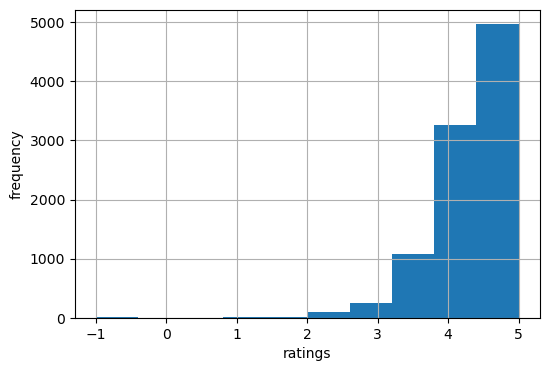

In [9]:
fig, ax = plt.subplots(figsize= (6, 4))
hist_plot = df['Rating'].hist(bins=10, ax= ax)
hist_plot.set_xlabel('ratings')
hist_plot.set_ylabel('frequency')

# 4) Building a Recommendation System using Sentiment Analysis

## a) Insights

- The data set has columns that increase the dimensions of the dataset as they have no use in our recommendation system. Those columns are: 'Unnamed: 0', 'City', 'Cuisine Style', 'Price Range', 'URL_TA', 'ID_TA'
> Therefore we may drop these columns.

- The ratings column in the dataset has scores lower than 0 which are invalid.
> Therefore we locate those rows and replace them with "nan" (Not a Number).

- The reviews in the dataset are written in such a matter that it may be incomprehensible. The date for which the review is written in included in the dataset as well as unnecessary brackets, apostrophes, and commas.
> Therefore we clean the reviews column by replacing all unnecessary features with empty strings.

## b) Data Cleaning & Preprocessing

In [10]:
df_SA = df.drop(['Unnamed: 0', 'City', 'Cuisine Style', 'Price Range', 'URL_TA', 'ID_TA'], axis=1)
df_SA.head()

,Name,Ranking,Rating,Number of Reviews,Reviews
0,Martine of Martine's Table,1.0,5.0,136.0,"[['Just like home', 'A Warm Welcome to Wintry ..."
1,De Silveren Spiegel,2.0,4.5,812.0,"[['Great food and staff', 'just perfect'], ['0..."
2,La Rive,3.0,4.5,567.0,"[['Satisfaction', 'Delicious old school restau..."
3,Vinkeles,4.0,5.0,564.0,"[['True five star dinner', 'A superb evening o..."
4,Librije's Zusje Amsterdam,5.0,4.5,316.0,"[['Best meal.... EVER', 'super food experience..."


In [11]:
df_SA.loc[df_SA['Rating'] < 0, 'Rating'] = np.nan

In [12]:
df_SA['Rating'].unique()

array([5. , 4.5, 4. , 3.5, 3. , 2.5, 2. , 1.5, 1. , nan])

In [13]:
df_SA['Reviews'] = (df['Reviews']
                 .str.replace(r"'", " ", regex = True)
                .str.replace(r",", " ", regex = True)
                 .str.replace(r'\[|\]', '', regex=True)
                 .str.replace(r'\d{2}/\d{2}/\d{4}', '', regex=True)
                 .str.strip())
print(df_SA['Reviews'])

0       Just like home    A Warm Welcome to Wintry Ams...
1                    Great food and staff    just perfect
2         Satisfaction    Delicious old school restaurant
3       True five star dinner    A superb evening of f...
4             Best meal.... EVER    super food experience
                              ...                        
9995       Very good lunch    Polite and friendly service
9996                                                     
9997    Only the Bread was good    A fantastic local r...
9998       Amazing all around!    Good eats Helpful Staff
9999    nice vegetarian options    You know exactly wh...
Name: Reviews, Length: 10000, dtype: object


In [14]:
df_SA['Reviews'][0]

'Just like home    A Warm Welcome to Wintry Amsterdam'

## c) Sentiment Scoring

Sentiment Scoring is basically scoring a string based on the words it carries. The scores are printed in the following format:

'neg': x1, 'neu': x2, 'pos': x3, 'compound': x4

The Negative (neg), Neutral (neu), and Positive (pos) are scored from 0:1.
Compound is scored from -1:1 -> If the score is closer to -1, the whole sentance is considered more negative, whereas if it is closer to 1, it is more positive


- Using SentimentIntensityAnalyzer() we are able to score the reviews in our Dataset. 
- To itterate through all the reviews and score them, we set a for loop and call the method
- We create a pandas dataframe and print it out to visualize each restaurant and their respective polarity scores 


In [15]:
Analyzer = SentimentIntensityAnalyzer()

In [16]:
Analyzer.polarity_scores('Just like home A Warm Welcome to Wintry Amsterdam')

{'neg': 0.0, 'neu': 0.403, 'pos': 0.597, 'compound': 0.7506}

In [17]:
# An empty dictionary to furthermore fill it with the restaurants and their given polarity scores
pol_scores_dictionary = {}

for i, data in tqdm(df_SA.iterrows()):
    try:
        # Calling the SentimentIntensityAnalyzer() trough Analyzer for each Review and results to the dictionary
        pol_scores_dictionary[data['Name']] = Analyzer.polarity_scores(data['Reviews'])
        
    except AttributeError:
        # In the exception where reviews are not strings, we convert them to a string
        data['Reviews'] = str( data['Reviews'])

0it [00:00, ?it/s]

In [18]:
# Converting the dictionary to a pandas dataframe
pol_scores_df = pd.DataFrame(pol_scores_dictionary).T
pol_scores_df = pol_scores_df.reset_index().rename(columns = {'index' : 'Name'})

pol_scores_df

,Name,neg,neu,pos,compound
0,Martine of Martine's Table,0.0,0.403,0.597,0.7506
1,De Silveren Spiegel,0.0,0.339,0.661,0.8316
2,La Rive,0.0,0.312,0.688,0.7650
3,Vinkeles,0.0,0.446,0.554,0.8271
4,Librije's Zusje Amsterdam,0.0,0.331,0.669,0.8442
...,...,...,...,...,...
9394,Sushiya 1 Uno,0.0,0.674,0.326,0.4404
9395,Luzuria Resto Bar,0.0,0.439,0.561,0.7501
9396,Jj Uno Al Cubo,0.0,0.000,0.000,0.0000
9397,alastruey,0.0,0.480,0.520,0.7579


## d) Merging Sentiment Scores & Meta Data

- Merging both dataframes to compare the polarity scores and the ratings
- Plotting Bar chart to visualizing each comparison

In [19]:
pol_scores_df = pol_scores_df.merge(df_SA, how ='left')

# Storing the merged datadrame as the inital dataframe df_SA 
df_SA = pol_scores_df
df_SA.head()

,Name,neg,neu,pos,compound,Ranking,Rating,Number of Reviews,Reviews
0,Martine of Martine's Table,0.0,0.403,0.597,0.7506,1.0,5.0,136.0,Just like home A Warm Welcome to Wintry Ams...
1,De Silveren Spiegel,0.0,0.339,0.661,0.8316,2.0,4.5,812.0,Great food and staff just perfect
2,La Rive,0.0,0.312,0.688,0.7650,3.0,4.5,567.0,Satisfaction Delicious old school restaurant
3,Vinkeles,0.0,0.446,0.554,0.8271,4.0,5.0,564.0,True five star dinner A superb evening of f...
4,Librije's Zusje Amsterdam,0.0,0.331,0.669,0.8442,5.0,4.5,316.0,Best meal.... EVER super food experience


**_Rating-Positive Bar Chart_**

<AxesSubplot:xlabel='Rating', ylabel='pos'>

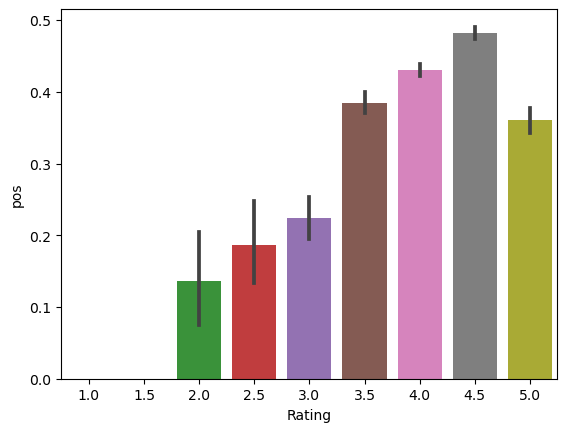

In [20]:
sns.barplot(data= df_SA, x="Rating", y= 'pos')

**_Rating-Neutral Bar Chart_**

<AxesSubplot:xlabel='Rating', ylabel='neu'>

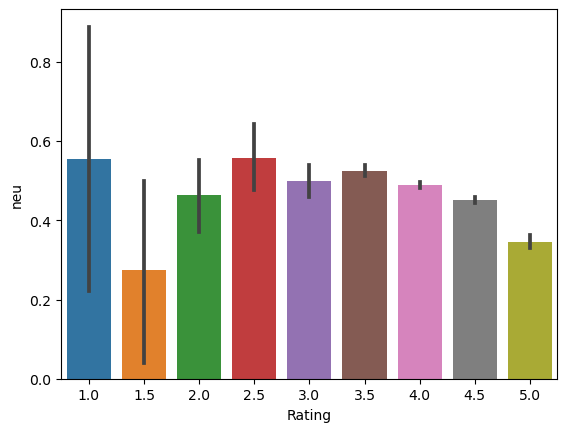

In [21]:
sns.barplot(data= df_SA, x="Rating", y= 'neu')

**_Rating-Negative Bar Chart_**

<AxesSubplot:xlabel='Rating', ylabel='neg'>

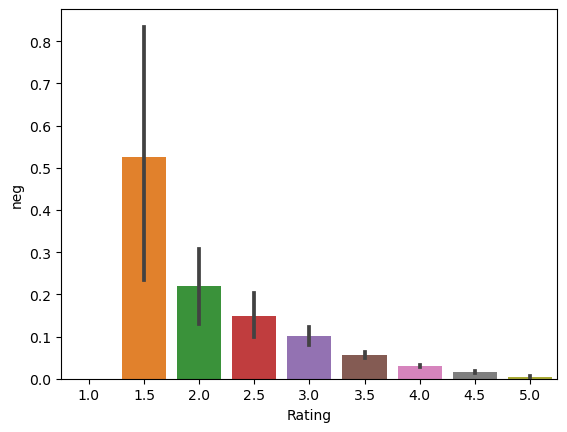

In [22]:
sns.barplot(data= df_SA, x="Rating", y= 'neg')

**_Rating-Compound Bar Chart_**

<AxesSubplot:xlabel='Rating', ylabel='compound'>

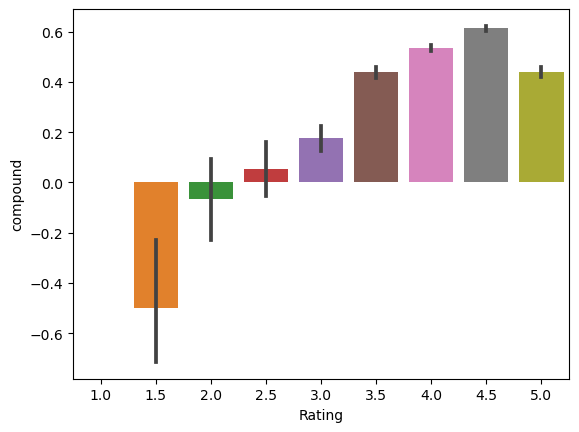

In [23]:
sns.barplot(data= df_SA, x="Rating", y= 'compound')

## e) Testing with Review Examples

Steps for the followinf test:
- we query where there is an x rating in our dataframe
- we sort the values by pos, neg, neu in descending to get the highest possible scores up top
- print out the top value (idex = 0)

These lines of code test the Sentiment Analysis: 

For example, the first test finds all 5 star rating restaurants and searches for the most positvely inclined review and prints it out.

In [24]:
df_SA.query('Rating == 5').sort_values('pos', ascending = False)['Reviews'].values[0]

'Fantastic'

In [25]:
df_SA.query('Rating == 1').sort_values('pos', ascending = False)['Reviews'].values[0]

'3 30 for a "pièce" of brownie and mistake...'

In [26]:
df_SA.query('Rating == 5').sort_values('neg', ascending = False)['Reviews'].values[0]

'Off the beaten track'

## f) The recommendation system

To recommend top 10 best reviewed restaurants:
- Sort the dataset based on the compound column in decensing order
- Crop the dataset to the first 10 rows 


In [27]:
df_SA_sorted = df_SA.sort_values('compound', ascending = False)
df_SA_top10 = df_SA_sorted[:10]
df_SA_top10

,Name,neg,neu,pos,compound,Ranking,Rating,Number of Reviews,Reviews
8023,Reserva Iberica,0.0,0.091,0.909,0.9682,2894.0,4.5,93.0,Love love love Gracious People Amazing J...
7135,L'eucaliptus,0.0,0.227,0.773,0.9661,1998.0,4.0,120.0,Great food at great value! Great value set ...
9042,Caradura Restaurant,0.0,0.205,0.795,0.9656,3947.0,4.0,29.0,Great food great value great service! Gre...
8226,Panika Barceloneta,0.0,0.275,0.725,0.9609,3101.0,4.5,17.0,nice food nice drinks and very lovely sta... ...
228,Tasty Asia,0.0,0.275,0.725,0.9609,207.0,4.5,150.0,Yummy! Nice service tasty food great pri... ...
3643,Athina Bistrot,0.0,0.187,0.813,0.9607,338.0,4.0,184.0,Good restaurant GREAT FOOD - GREAT SPOT - G...
7275,Lido,0.0,0.236,0.764,0.9607,2137.0,4.0,124.0,Good food good value. Cute place with grea...
3630,Erotokritos Souvlaki,0.0,0.257,0.743,0.9605,325.0,4.5,53.0,Amazing!! Best giros in town!! Great food a...
6437,Chicha Limona,0.0,0.267,0.733,0.9595,1306.0,4.0,353.0,Nice place excellent food excellent verm... ...
5483,Ayres del Sur,0.0,0.218,0.782,0.9583,373.0,4.5,158.0,Nice service! Fair prices! Great restaurant...


In [28]:
print ("According to the reviews, we recommend you the following restaurants: ")
df_SA_top10['Name']

According to the reviews, we recommend you the following restaurants: 


8023         Reserva Iberica
7135            L'eucaliptus
9042     Caradura Restaurant
8226      Panika Barceloneta
228               Tasty Asia
3643          Athina Bistrot
7275                    Lido
3630    Erotokritos Souvlaki
6437           Chicha Limona
5483           Ayres del Sur
Name: Name, dtype: object

## g) Visualizing the final recommendation

In [29]:
df_SA_top10 = df_SA_top10.drop(['neg', 'neu', 'pos', 'compound', 'Ranking', 'Number of Reviews'], axis=1)
df_SA_top10 = df_SA_top10.set_index('Name').rename_axis('Recommended Restaurants')
df_SA_top10

,Rating,Reviews
Recommended Restaurants,,
Reserva Iberica,4.5,Love love love Gracious People Amazing J...
L'eucaliptus,4.0,Great food at great value! Great value set ...
Caradura Restaurant,4.0,Great food great value great service! Gre...
Panika Barceloneta,4.5,nice food nice drinks and very lovely sta... ...
Tasty Asia,4.5,Yummy! Nice service tasty food great pri... ...
Athina Bistrot,4.0,Good restaurant GREAT FOOD - GREAT SPOT - G...
Lido,4.0,Good food good value. Cute place with grea...
Erotokritos Souvlaki,4.5,Amazing!! Best giros in town!! Great food a...
Chicha Limona,4.0,Nice place excellent food excellent verm... ...


# 5) Building a Recommendation System Using a Content Based Recommendation Model 

## a) Insights

- The data set has columns that increase the dimensions of the dataset as they have no use in our recommendation system. Those columns are: 'Unnamed: 0', 'Ranking', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'
> Therefore we may drop these columns.

- The cuisine styles in the dataset are written in such a matter that it may be incomprehensible. Unnecessary brackets, and apostrophes are included in the dataset.
> Therefore we clean the reviews column by replacing all unnecessary features with empty strings.

- The Price Ranges for the retaurants are expressed with dollar signs.
> Therefore we clean the Price Range column by setting each sum of dollar signs to a comprehensible string.

## b) Data Cleaning & Preprocessing

In [30]:
df_CBR = df.drop(['Unnamed: 0', 'Ranking', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'], axis=1)
df_CBR.head()

,Name,City,Cuisine Style,Rating,Price Range
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",5.0,$$ - $$$
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",4.5,$$$$
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",4.5,$$$$
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",5.0,$$$$
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",4.5,$$$$


In [31]:
df_CBR['Cuisine Style'] = (df_CBR['Cuisine Style']
                 .str.replace(r"'", " ", regex = True)
                 .str.replace('[', '', regex=True)
                 .str.replace(']', '', regex=True)
                 .str.strip())

print(df_CBR['Cuisine Style'])

0                             French ,  Dutch ,  European
1       Dutch ,  European ,  Vegetarian Friendly ,  Gl...
2       Mediterranean ,  French ,  International ,  Eu...
3       French ,  European ,  International ,  Contemp...
4       Dutch ,  European ,  International ,  Vegetari...
                              ...                        
9995                   Argentinean ,  Vegetarian Friendly
9996                                                  NaN
9997                                                  NaN
9998                                              Spanish
9999      Mediterranean ,  Spanish ,  Vegetarian Friendly
Name: Cuisine Style, Length: 10000, dtype: object


In [32]:
# Calling the first row in the Cuisine Style column to verify that the code ran correctly.
df_CBR['Cuisine Style'][0]

'French ,  Dutch ,  European'

In [33]:
# Searching for unique values in the Price Range Column
df_CBR['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [34]:
# Locating each unique value and converting it to its respective string
df_CBR.loc[df_CBR['Price Range'] == "$", 'Price Range'] = "Low Class"
df_CBR.loc[df_CBR['Price Range'] == "$$ - $$$", 'Price Range'] = "Middle Class"
df_CBR.loc[df_CBR['Price Range'] == "$$$$", 'Price Range'] = "High Class"

# Searching for unique values in the Price Range Column again to verify that the code ran correctly
df_CBR['Price Range'].unique()

array(['Middle Class', 'High Class', 'Low Class', nan], dtype=object)

## c) The Recommendation System 

Steps for the following recommendation system:

- Choosing a random restaurant to work with.
- Setting a function that creates a seperate dataframe with the rows that shares the same Price Range with the chosen restaurant.
- Using TfidfVectorizer() we build the Vector Space Model
- Creating a matrix that compares all cuisine types, of the updated dataset, with themselves
- Finding the indexes of all previously recommended restaurants through the Price Range
- Setting a function that runs the recommendation process 

In [35]:
random_restaurant = random.choice(df_CBR['Name'])
random_restaurant

'Konservokouti'

In [36]:
def get_pricerange_sim(Name):
    restaurant = Name
    # Locating the Resaurant and store its price range in PriceRange
    PriceRange = df_CBR.loc[df_CBR['Name'] == restaurant, 'Price Range'].values[0]
    
    # Locating all rows that share that same prince range and set them in a dataframe
    restaurants_df = df_CBR.loc[df_CBR['Price Range'] == PriceRange]
    
    # Returning the dataframe
    return restaurants_df

df_Recommended_through_PR = get_pricerange_sim(random_restaurant)

In [37]:
df_Recommended_through_PR.reset_index(inplace= True)
df_Recommended_through_PR

,index,Name,City,Cuisine Style,Rating,Price Range
0,0,Martine of Martine's Table,Amsterdam,"French , Dutch , European",5.0,Middle Class
1,6,Zaza's,Amsterdam,"French , International , Mediterranean , Eu...",4.5,Middle Class
2,10,The Happy Bull,Amsterdam,"American , Bar , European , Vegetarian Frie...",4.5,Middle Class
3,11,Gartine,Amsterdam,"French , Dutch , International , European ,...",4.5,Middle Class
4,13,Biercafe Gollem,Amsterdam,"Bar , Pub",4.5,Middle Class
...,...,...,...,...,...,...
5320,9986,La font de les muses,Barcelona,"Mediterranean , European , Spanish , Seafoo...",3.5,Middle Class
5321,9990,Jose Luis Restaurante,Barcelona,"Mediterranean , Spanish",3.5,Middle Class
5322,9993,Galicia,Barcelona,"Mediterranean , European , Spanish , Bar",4.0,Middle Class
5323,9995,Luzuria Resto Bar,Barcelona,"Argentinean , Vegetarian Friendly",4.5,Middle Class


In [38]:
TfV = TfidfVectorizer()

In [39]:
# Building the Vector Space Model which creates the matrix for us
TfV_matrix = TfV.fit_transform(df_Recommended_through_PR['Cuisine Style'])

# Using the linear_kernel we develop cosine similarities that creates a refrence of each cuisine with the other
cos_sim_PR = linear_kernel(TfV_matrix, TfV_matrix)

In [40]:
# Store the indexes of the previously recommended restaurants through the Price Range in idx.
idx = pd.Series(df_Recommended_through_PR.index, index= df_Recommended_through_PR['Name'])

print(idx)

Name
Martine of Martine's Table       0
Zaza's                           1
The Happy Bull                   2
Gartine                          3
Biercafe Gollem                  4
                              ... 
La font de les muses          5320
Jose Luis Restaurante         5321
Galicia                       5322
Luzuria Resto Bar             5323
Origin                        5324
Length: 5325, dtype: int64


In [41]:
def get_recommendation (Name, cos_sim_PR = cos_sim_PR):
    # Getting the index of the randomly generated restaurant name:
    idex = idx[Name]

    # Comparing the similarity scores to the rest:
    scores = enumerate(cos_sim_PR[idex])

    # Sorting it
    scores = sorted(scores, key= lambda x: x[1], reverse=True)

    # Isolating the top 10 most similar outputs
    scores = scores[1:11]

    # Extracting the index from scores
    sim_index = [i[0] for i in scores]

    # Returning the title
    print(df_Recommended_through_PR['Name'].iloc[sim_index])

In [42]:
print('As you have tried, ', random_restaurant, " , we recommend you the following restaurants: ")
get_recommendation(random_restaurant)

As you have tried,  Konservokouti  , we recommend you the following restaurants: 
2143                    Ydroussa
2220                 Kalipeteira
2221                Meze Gallery
2236      Peinirli Eleftheriadis
2271        Acropol Vintage Cafe
2274    Giorti Restaurant & Cafe
2275           Avli Gefsipoleion
2280       Despina Millefeuilles
2282              To Pilioritiko
2284                   Vasilikos
Name: Name, dtype: object


## Conclusion 

In conclusion, my recommendation system is well presented and well functionable. Its strongest point is that the results turned out correct. However, the code was only done on the first 10 000 rows due to a personal slow CPU, which could mean that the data might need more cleaning or preprocessing for the recommendation systems to work. 

# SUBMISSION FORM

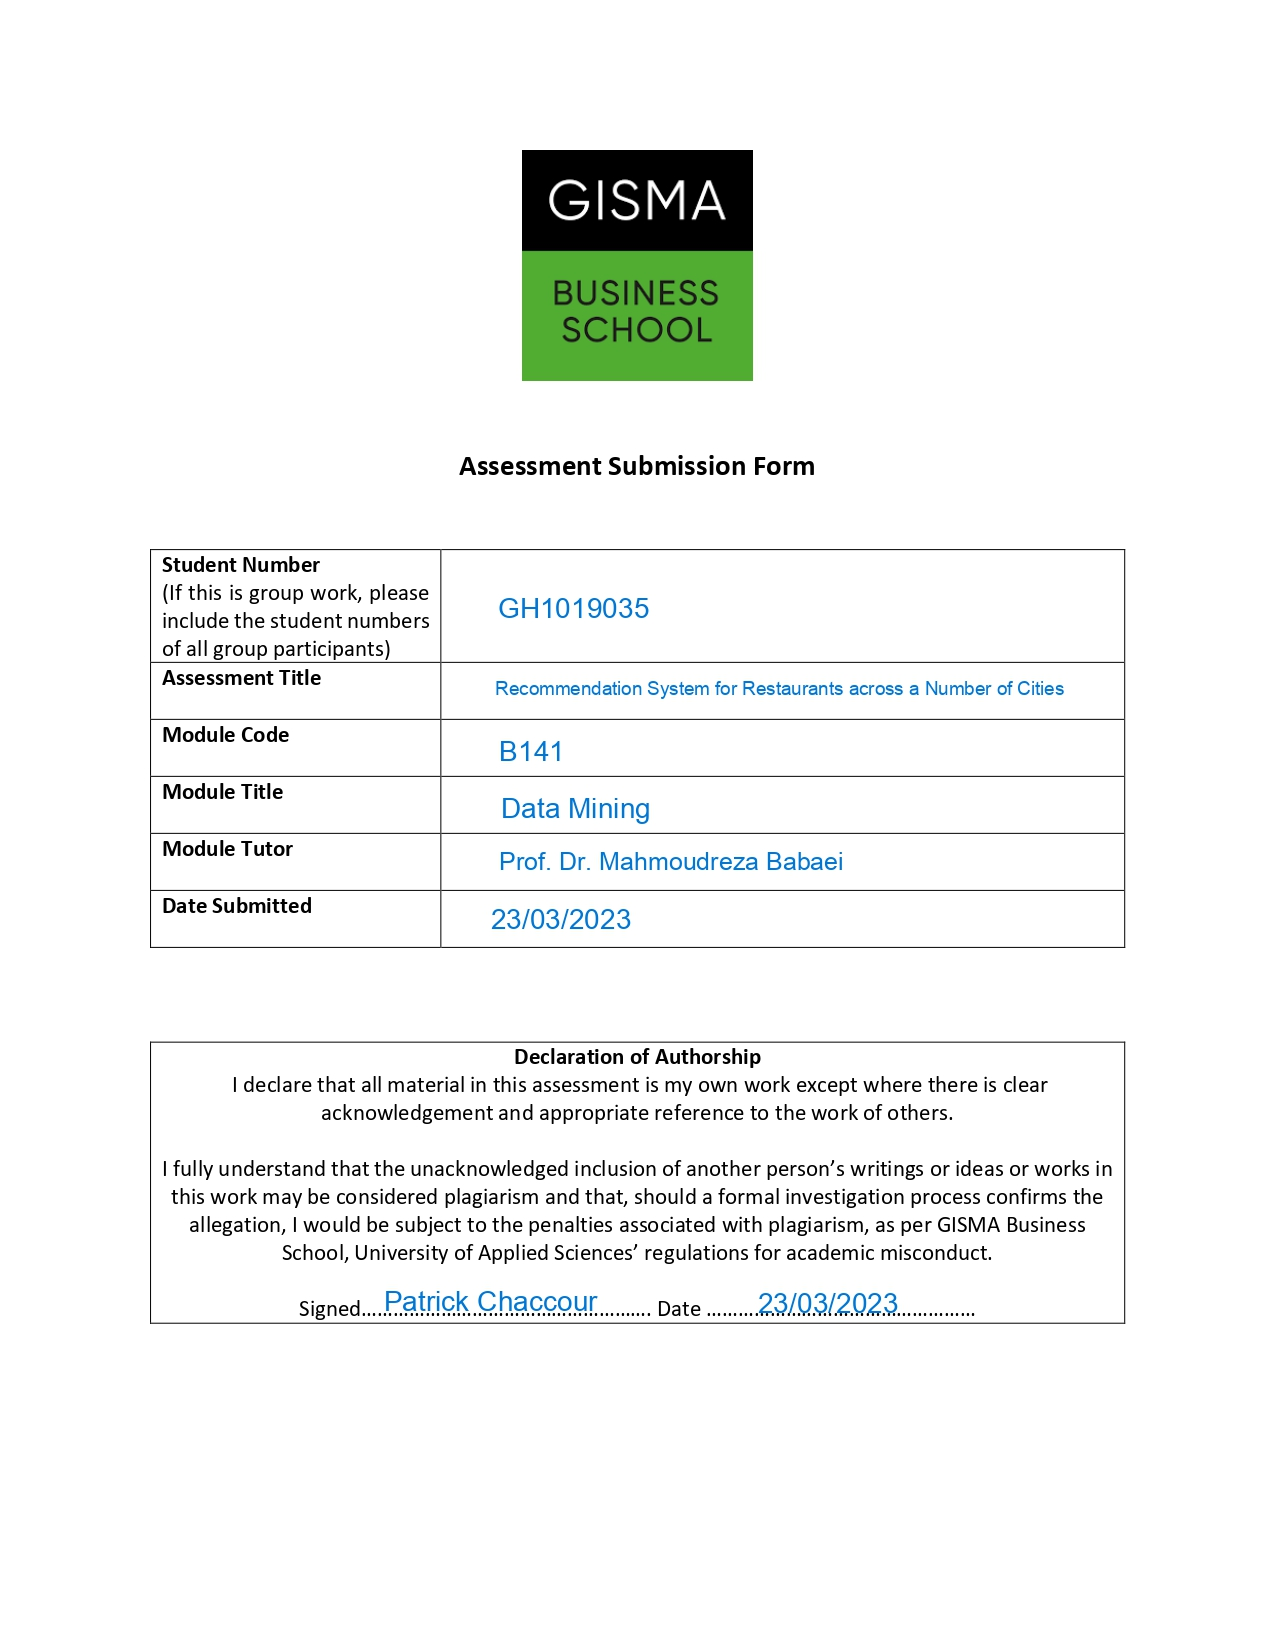

In [43]:
from IPython.display import Image

Image(filename='SubmissionForm_DataMining.jpg')